Заведем системные функции

In [199]:
import numpy as np
import matplotlib.pyplot as plt

In [200]:
N_GRAPH = 1000

In [201]:
def get_xs(xl, xr, n):
    if n == 1:
        return np.array([xl])
    s = (xr - xl) / (n - 1)
    return np.arange(xl, xr + 10 ** -9, s)

In [202]:
def get_diff(xs, f1, f2):
    return list(map(lambda x: abs(f1(x) - f2(x)), xs))

In [203]:
def draw(xs, ys, names=None):
    if type(xs) is not list:
        xs = [xs]
        ys = [ys]
        if names is not None:
            names = [names]
            
    n = len(xs)
    for i in range(n):
        plt.plot(xs[i], ys[i])
        
    if names is not None:
        plt.legend(names)
    plt.show()

# Упражнение 10

Дан дифур:
$$\begin{cases} 
y''(x) = a^2y(x)\\
y(0) = 1\\
y'(0) = -a
\end{cases}$$
При $x \in [0, T]$.
Перепишем уравнения в виде системы первого порядка:
$$\begin{cases}
y'(x) = y_1(x)\\
y_1'(x) = a^2y(x)\\
y(0) = 1\\
y_1(0) = -a
\end{cases}$$
А такое просто решить методом Эйлера:
$$y_{k+1} = y_k + h y_{1_k}$$
$$y_{1_{k+1}} = y_{1_k} + h a^2 y_{k}$$

Сначала запишем параметры и функции для шагов:

In [204]:
T = [10]
a = [1, np.sqrt(20)]
N = [10, 50, 100]

def get_f0(a):
    def f0(x, y0, y1):
        return y1
    return f0

def get_f1(a):
    def f1(x, y0, y1):
        return a ** 2 * y0
    return f1

def get_y0(a):
    return 1

def get_y1(a):
    return -a

def get_y(a):
    def y(x):
        return np.e ** (-a * x)
    return y

Теперь напишем метод Эйлера:

In [205]:
def euler(f0, f1, y0, y1, N, T):
    ys0 = [y0]
    h = T / N
    x = 0
    for i in range(N):
        y0, y1 = y0 + h * f0(x, y0, y1), y1 + h * f1(x, y0, y1)
        ys0.append(y0)
        x += h
    return ys0

Построим функции для различных параметров:

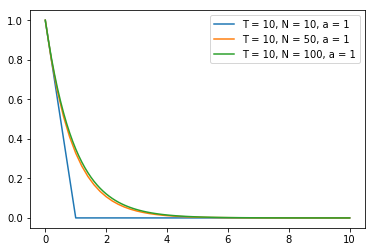

In [206]:
ai = a[0]

xs, ys, names = [], [], []

for Ti in T:
    for Ni in N:
        xsi = get_xs(0, Ti, Ni + 1)
        ysi = euler(get_f0(ai), get_f1(ai), 
                   get_y0(ai), get_y1(ai), 
                   Ni, Ti)
        xs.append(xsi)
        ys.append(ysi)
        names.append("T = " + str(Ti) + ", N = " + str(Ni) + ", a = " + str(ai))
        
draw(xs, ys, names)

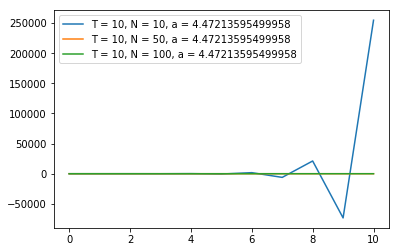

In [207]:
ai = a[1]

xs, ys, names = [], [], []

for Ti in T:
    for Ni in N:
        xsi = get_xs(0, Ti, Ni + 1)
        ysi = euler(get_f0(ai), get_f1(ai), 
                   get_y0(ai), get_y1(ai), 
                   Ni, Ti)
        xs.append(xsi)
        ys.append(ysi)
        names.append("T = " + str(Ti) + ", N = " + str(Ni) + ", a = " + str(ai))
        
draw(xs, ys, names)

Как видно из графиков, $N=10$ дает плохую точность (особенно для $a = \sqrt{20}$).

Посмотрим теперь на график максимального отклонения от правильной функции на отрезке $x \in [0, T]$.

In [208]:
def get_max_error(solver, Ti, Ni, ai):
    xsi = get_xs(0, Ti, Ni + 1)
    ysi = solver(get_f0(ai), get_f1(ai), 
               get_y0(ai), get_y1(ai), 
               Ni, Ti)
    ysr = list(map(get_y(ai), xsi))
    return max(get_diff(list(range(len(xsi))),
                        lambda j: ysi[j],
                         lambda j: ysr[j]))

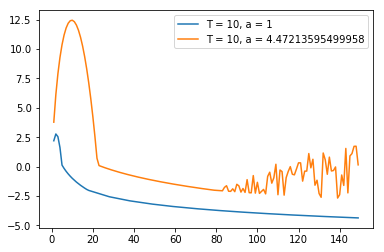

In [209]:
ns = list(range(1, 150))
Ns, ys, names = [], [], []
for Ti in T:
    for ai in a:
        nsi = ns
        ysi = list(map(lambda n: get_max_error(euler, Ti, n, ai), nsi))
        Ns.append(nsi)
        ys.append(ysi)
        names.append("T = " + str(Ti) + ", a = " + str(ai))
        
ys = np.array(ys)
ys = np.log(ys)

draw(Ns, ys, names)

Как видно, ни в одном случае ошибка не дошла до $10^{-3}$ ($e^{-5} > 10^{-3}$). Также можно заметить, что для $a = \sqrt{20}$ максимальная ошибка достигается при $N=10$, а также,что при $N > 80$ ошибка начинает увеличиваться, что связано с погрешностью вычислений. А вот для $a = 1$ ошибка монотонно убывает.

Теперь научимся решать задачу методом Рунге-Кутта:

In [210]:
def runge(f0, f1, y0, y1, N, T):
    b = 1 / 2
    ys0 = [y0]
    h = T / N
    x = 0
    for i in range(N):
        y0, y1 = y0 + h * ( (1 - b) * f0(x, y0, y1) + 
                            b * f0(x + h / (2 * b),
                                   y0 + h / (2 * b) * f0(x, y0, y1),
                                   y1 + h / (2 * b) * f1(x, y0, y1)) ), \
                 y1 + h * ( (1 - b) * f1(x, y0, y1) +
                            b * f1(x + h / (2 * b), 
                                   y0 + h / (2 * b) * f0(x, y0, y1),
                                   y1 + h / (2 * b) * f1(x, y0, y1)) )
        ys0.append(y0)
        x += h
    return ys0

И сравним его с методом Эйлера:

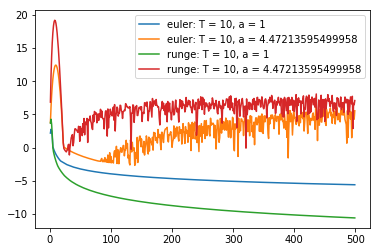

In [211]:
ns = list(range(1, 500))
Ns, ys, names = [], [], []
for solver, solver_name in [(euler, "euler"), (runge, "runge")]:
    for Ti in T:
        for ai in a:
            nsi = ns
            ysi = list(map(lambda n: get_max_error(solver, Ti, n, ai), nsi))
            Ns.append(nsi)
            ys.append(ysi)
            names.append(solver_name + ": T = " + str(Ti) + ", a = " + str(ai))
        
ys = np.array(ys)
ys = np.log(ys)

draw(Ns, ys, names)

Для $a = 1$ ошибка в методе Ранге-Кутта убывает еще быстрее,чем в методе Эйлера и даже преодалевает значение $10^{-3}$ ($e^{-10} < 10^{-3}$).
А вот для $a = \sqrt{20}$ метод Ранге-Кутта выглядит хуже. Но это связано с тем, что у него бустрее накапливается ошибка из-за погрешностей в вычислениях. 